In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

from scipy.special import kl_div
from typing import Union, Tuple, Dict
from scipy.spatial.distance import jensenshannon

In [2]:
BASE = "/mnt/data/kgutjahr/datasets/DVM"
TABLES= os.path.join(BASE, "tables")
FEATURES = os.path.join(BASE, "images")

In [3]:
color_coding = {0: 'Beige',
                1: 'Black',
                2: 'Blue', 
                3: 'Bronze', 
                4: 'Brown', 
                5: 'Burgundy', 
                6: 'Gold', 
                7: 'Green', 
                8: 'Grey', 
                9: 'Indigo', 
                10: 'Magenta', 
                11: 'Maroon', 
                12: 'Multicolour', 
                13: 'Navy', 
                14: 'Orange', 
                15: 'Pink', 
                16: 'Purple', 
                17: 'Red', 
                18: 'Silver', 
                19: 'Turquoise', 
                20: 'White', 
                21: 'Yellow'}

In [4]:
label_coding = {1: 'Bentley Bentayga',
                3: 'Bentley Continental',
                13: 'Chevrolet Spark',
                30: 'Citroen C3 Picasso',
                32: 'Citroen C4',
                33: 'Citroen C4 Cactus',
                34: 'Citroen C4 Picasso',
                35: 'Citroen C5',
                40: 'Citroen Grand C4 Picasso',
                46: 'Citroen Xsara Picasso',
                48: 'Citroen C1',
                49: 'Citroen C2',
                50: 'Citroen C3',
                51: 'Citroen C3 Aircross',
                52: 'Citroen DS3',
                53: 'Citroen DS4',
                54: 'Citroen DS5',
                55: 'Dacia Duster',
                57: 'Dacia Sandero',
                80: 'Ferrari 488',
                82: 'Fiat Bravo',
                84: 'Fiat Doblo',
                86: 'Fiat Grande Punto',
                89: 'Fiat Panda',
                90: 'Fiat Punto',
                91: 'Fiat 500',
                92: 'Fiat Punto Evo',
                98: 'Fiat Tipo',
                100: 'Fiat 500L',
                101: 'Fiat 500X',
                103: 'Ford B-Max',
                104: 'Ford Fiesta',
                105: 'Ford Focus',
                106: 'Ford Focus C-Max',
                107: 'Ford Fusion',
                108: 'Ford Galaxy',
                109: 'Ford C-Max',
                110: 'Ford Grand C-Max',
                112: 'Ford Ka',
                113: 'Ford Kuga',
                115: 'Ford Mondeo',
                116: 'Ford Mustang',
                118: 'Ford S-Max',
                121: 'Ford EcoSport',
                122: 'Ford Edge',
                124: 'Abarth 595',
                125: 'Honda Accord',
                127: 'Honda Jazz',
                131: 'Honda Civic',
                132: 'Honda CR-V',
                135: 'Honda HR-V',
                136: 'Honda Insight',
                139: 'Hyundai i30',
                140: 'Hyundai i40',
                141: 'Hyundai i800',
                143: 'Hyundai ix20',
                144: 'Hyundai ix35',
                148: 'Hyundai Santa Fe',
                152: 'Hyundai Tucson',
                156: 'Hyundai Getz',
                157: 'Hyundai i10',
                158: 'Hyundai i20',
                162: 'Infiniti Q30',
                169: 'Jaguar F-PACE',
                170: 'Jaguar F-Type',
                171: 'Jaguar S-Type',
                172: 'Jaguar X-Type',
                173: 'Jaguar XE',
                174: 'Jaguar XF',
                175: 'Jaguar XJ',
                176: 'Jaguar XK',
                177: 'Jeep Cherokee',
                180: 'Jeep Grand Cherokee',
                182: 'Jeep Renegade',
                184: 'Kia Carens',
                186: 'Kia Sorento',
                187: 'Kia Soul',
                188: 'Kia Sportage',
                191: 'Kia Venga',
                192: "Kia 'Cee''d'",
                195: 'Kia Niro',
                196: 'Kia Optima',
                197: 'Kia Picanto',
                198: "Kia 'Pro_Cee''d'",
                199: 'Kia Rio',
                204: 'Land Rover Discovery Sport',
                205: 'Land Rover Freelander',
                206: 'Land Rover Range Rover',
                207: 'Land Rover Range Rover Evoque',
                208: 'Land Rover Range Rover Sport',
                209: 'Land Rover Range Rover Velar',
                210: 'Land Rover Discovery',
                214: 'Lexus NX 300h',
                215: 'Lexus GS 250',
                217: 'Lexus RX 200t',
                219: 'Lexus IS 250',
                221: 'Alfa Romeo Giulietta',
                223: 'Alfa Romeo MiTo',
                233: 'MG MG3',
                235: 'MG TF',
                239: 'MINI Clubman',
                240: 'MINI Convertible',
                241: 'MINI Countryman',
                242: 'MINI Coupe',
                243: 'MINI Hatch',
                244: 'MINI Paceman',
                245: 'MINI Roadster',
                249: 'Maserati Ghibli',
                257: 'Mazda Mazda2',
                258: 'Mazda Mazda3',
                259: 'Mazda Mazda5',
                260: 'Mazda Mazda6',
                265: 'Mazda CX-3',
                266: 'Mazda CX-5',
                271: 'Mercedes-Benz B Class',
                272: 'Mercedes-Benz C Class',
                274: 'Mercedes-Benz CLA Class',
                275: 'Mercedes-Benz CLC Class',
                276: 'Mercedes-Benz CLK',
                277: 'Mercedes-Benz CLS',
                278: 'Mercedes-Benz E Class',
                281: 'Mercedes-Benz GLA Class',
                282: 'Mercedes-Benz GLC Class',
                283: 'Mercedes-Benz GLE Class',
                285: 'Mercedes-Benz M Class',
                287: 'Mercedes-Benz S Class',
                288: 'Mercedes-Benz SL Class',
                290: 'Mercedes-Benz SLK',
                294: 'Mercedes-Benz A Class',
                295: 'Mitsubishi ASX',
                298: 'Mitsubishi Lancer',
                299: 'Mitsubishi Mirage',
                300: 'Mitsubishi Outlander',
                301: 'Mitsubishi Shogun',
                307: 'Mitsubishi Colt',
                308: 'Mitsubishi Eclipse Cross',
                311: 'Nissan GT-R',
                312: 'Nissan Juke',
                314: 'Nissan Micra',
                317: 'Nissan Note',
                323: 'Nissan Pulsar',
                324: 'Nissan Qashqai',
                325: 'Nissan Qashqai+2',
                328: 'Nissan X-Trail',
                333: 'Peugeot 208',
                334: 'Peugeot 3008',
                337: 'Peugeot 308',
                342: 'Peugeot 5008',
                343: 'Peugeot 508',
                346: 'Peugeot 107',
                349: 'Peugeot Partner Tepee',
                350: 'Peugeot RCZ',
                352: 'Peugeot 108',
                353: 'Peugeot 2008',
                354: 'Peugeot 206',
                355: 'Peugeot 207',
                360: 'Porsche Macan',
                361: 'Porsche Panamera',
                363: 'Porsche 718 Cayman',
                364: 'Porsche 911',
                365: 'Porsche Boxster',
                366: 'Porsche Cayenne',
                367: 'Porsche Cayman',
                373: 'Renault Captur',
                374: 'Renault Koleos',
                375: 'Renault Laguna',
                376: 'Renault Megane',
                378: 'Renault Scenic',
                379: 'Renault Twingo',
                380: 'Renault Clio',
                385: 'Renault Grand Modus',
                386: 'Renault Grand Scenic',
                387: 'Renault Kadjar',
                399: 'SEAT Alhambra',
                400: 'SEAT Leon',
                401: 'SEAT Mii',
                403: 'SEAT Altea',
                406: 'SEAT Ateca',
                408: 'SEAT Exeo',
                409: 'SEAT Ibiza',
                410: 'Audi A1',
                411: 'Audi A6 Allroad',
                412: 'Audi A7',
                413: 'Audi A8',
                414: 'Audi Q2',
                415: 'Audi Q3',
                417: 'Audi Q5',
                418: 'Audi Q7',
                419: 'Audi R8',
                420: 'Audi A3',
                421: 'Audi TT',
                422: 'Audi A4',
                423: 'Audi A5',
                424: 'SKODA Citigo',
                425: 'SKODA Yeti',
                426: 'SKODA Fabia',
                427: 'SKODA Karoq',
                428: 'SKODA Kodiaq',
                429: 'SKODA Octavia',
                430: 'SKODA Rapid',
                431: 'SKODA Roomster',
                432: 'SKODA Superb',
                433: 'Saab 09-Mar',
                434: 'Saab 09-May',
                435: 'Smart forfour',
                436: 'Smart fortwo',
                438: 'Ssangyong Korando',
                442: 'Ssangyong Tivoli',
                446: 'Subaru XV',
                447: 'Subaru Forester',
                448: 'Subaru Impreza',
                452: 'Subaru Outback',
                453: 'Suzuki Alto',
                454: 'Suzuki Swift',
                455: 'Suzuki SX4',
                456: 'Suzuki SX4 S-Cross',
                457: 'Suzuki Vitara',
                459: 'Suzuki Baleno',
                460: 'Suzuki Celerio',
                461: 'Suzuki Grand Vitara',
                466: 'Suzuki Splash',
                469: 'BMW 1 Series',
                471: 'BMW 7 Series',
                472: 'BMW 2 Series',
                474: 'BMW i8',
                475: 'BMW X1',
                476: 'BMW X3',
                477: 'BMW X4',
                478: 'BMW X5',
                479: 'BMW X6',
                481: 'BMW Z4',
                482: 'BMW 3 Series',
                483: 'BMW 5 Series',
                484: 'Toyota Corolla',
                486: 'Toyota iQ',
                487: 'Toyota Land Cruiser',
                493: 'Toyota Auris',
                494: 'Toyota Prius',
                495: 'Toyota RAV4',
                497: 'Toyota Avensis',
                498: 'Toyota Verso',
                499: 'Toyota Yaris',
                501: 'Toyota AYGO',
                502: 'Toyota C-HR',
                504: 'Vauxhall ADAM',
                505: 'Vauxhall Crossland X',
                507: 'Vauxhall Grandland X',
                508: 'Vauxhall Insignia',
                509: 'Vauxhall Meriva',
                510: 'Vauxhall Mokka',
                513: 'Vauxhall Agila',
                515: 'Vauxhall Tigra',
                516: 'Vauxhall Vectra',
                517: 'Vauxhall Viva',
                521: 'Vauxhall Zafira',
                523: 'Vauxhall Antara',
                524: 'Vauxhall Astra',
                526: 'Vauxhall Corsa',
                528: 'Volkswagen CC',
                529: 'Volkswagen Eos',
                530: 'Volkswagen Fox',
                531: 'Volkswagen Golf',
                532: 'Volkswagen Jetta',
                535: 'Volkswagen Passat',
                537: 'Volkswagen Polo',
                538: 'Volkswagen Scirocco',
                539: 'Volkswagen Sharan',
                540: 'Volkswagen T-Roc',
                541: 'Volkswagen Tiguan',
                542: 'Volkswagen Touareg',
                543: 'Volkswagen Touran',
                544: 'Volkswagen Beetle',
                545: 'Volkswagen up!',
                549: 'Volvo C30',
                550: 'Volvo V60',
                551: 'Volvo V70',
                553: 'Volvo XC60',
                554: 'Volvo XC70',
                555: 'Volvo XC90',
                556: 'Volvo C70',
                557: 'Volvo S40',
                558: 'Volvo S60',
                559: 'Volvo S80',
                560: 'Volvo S90',
                561: 'Volvo V40',
                562: 'Volvo V50'}

In [5]:
def get_color_counts(df: pd.DataFrame) -> pd.DataFrame:
    color_counts = df["Color"].value_counts()
    color_percentages = df["Color"].value_counts(normalize=True) * 100

    # Optional: Combine into one DataFrame for clarity
    color_summary = pd.DataFrame({
        'Count': color_counts,
        'Percentage': color_percentages.round(3)
    })
    return color_summary

In [6]:
def plot_color_distributions(df: pd.DataFrame) -> None:
    plt.figure(figsize=(10, 6))
    ax = df["Count"].plot(kind='bar', color='skyblue', edgecolor='black', width=1)

    # Customize the plot
    plt.title('Color distribution')
    plt.xlabel('Colors')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, fontsize=10)  # Rotate labels for better readability
    plt.tight_layout()

    # Show the plot
    plt.show()

# Get color distribution of entire Dataset

In [7]:
data_path = os.path.join(FEATURES, "full_data_df_all_views.csv")
data = pd.read_csv(data_path)
data['Color'] = data['Color'].map(color_coding)
data

,Unnamed: 0,Adv_ID,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,Door_num,Entry_price,Engine_size,Color,Bodytype,Gearbox,Fuel_type,Genmodel_ID,Image_name,Predicted_viewpoint
0,16537,29_1$$1,0.012811,0.611842,0.876887,-0.968248,-0.160462,0.135216,0.618330,-0.436833,-0.370720,Silver,7,0,8,0,Ford$$B-Max$$2016$$Silver$$29_1$$1$$image_1.jpg,0
1,16538,29_1$$4,0.012811,-1.311853,0.876887,-0.817438,-0.203351,0.135216,0.618330,-0.436833,-1.148269,Black,7,1,8,0,Ford$$B-Max$$2016$$Black$$29_1$$4$$image_2.jpg,270
2,16540,29_1$$21,0.012811,0.611842,0.876887,-0.860069,-0.182743,0.135216,0.618330,-0.436833,-0.500312,Red,7,1,1,0,Ford$$B-Max$$2016$$Red$$29_1$$21$$image_1.jpg,0
3,16541,29_1$$36,0.012811,1.092766,0.876887,-0.642168,-0.111910,0.135216,0.618330,-0.436833,-1.148269,Black,7,1,8,0,Ford$$B-Max$$2016$$Black$$29_1$$36$$image_0.jpg,0
4,16543,29_1$$40,0.012811,-0.350005,0.876887,-0.245536,-0.243919,0.135216,0.618330,-0.436833,-0.500312,White,7,1,1,0,Ford$$B-Max$$2016$$White$$29_1$$40$$image_0.jpg,225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9574,202507,95_33$$1104,0.012811,-0.830929,0.182476,0.528388,-0.419680,-1.059812,-1.395615,-0.708715,-1.148269,Silver,5,1,8,8,Volkswagen$$up!$$2013$$Silver$$95_33$$1104$$im...,0
9575,202508,95_33$$1110,0.012811,1.092766,0.182476,-0.592382,-0.338220,-1.059812,0.618330,-0.708715,-1.148269,Grey,5,1,8,8,Volkswagen$$up!$$2013$$Grey$$95_33$$1110$$imag...,225
9576,202509,95_33$$1136,0.012811,-0.350005,0.182476,0.339064,-0.393246,-1.059812,0.618330,-0.708715,-1.148269,Silver,5,0,8,8,Volkswagen$$up!$$2013$$Silver$$95_33$$1136$$im...,90
9577,202510,95_33$$1168,0.012811,0.611842,0.182476,0.668698,-0.446384,-1.059812,-1.395615,-0.708715,-1.148269,Silver,5,1,8,8,Volkswagen$$up!$$2013$$Silver$$95_33$$1168$$im...,135


In [8]:
color_counts = get_color_counts(df=data)
color_counts

,Count,Percentage
Black,1690,17.643
White,1501,15.670
Red,1486,15.513
Blue,1343,14.020
Silver,1259,13.143
Grey,1017,10.617
Yellow,326,3.403
Orange,291,3.038
Green,247,2.579
Brown,231,2.412


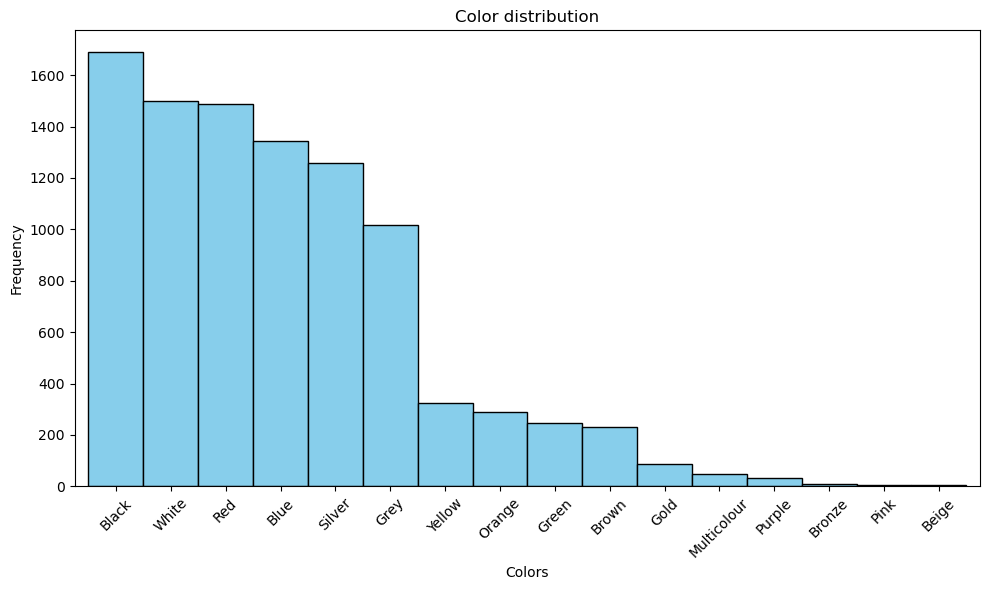

In [9]:
plot_color_distributions(df=color_counts)

## Plot Color Distribution of splits

In [10]:
train_df = pd.read_csv(os.path.join(FEATURES,f'dvm_full_features_train_noOH_all_views.csv'))
train_df['Color'] = train_df['Color'].map(color_coding)
val_df = pd.read_csv(os.path.join(FEATURES,f'dvm_full_features_val_noOH_all_views.csv'))
val_df['Color'] = val_df['Color'].map(color_coding)
test_df = pd.read_csv(os.path.join(FEATURES,f'dvm_full_features_test_noOH_all_views.csv'))
test_df['Color'] = test_df['Color'].map(color_coding)

In [11]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

print(f"Total Size: {train_df.shape[0] + val_df.shape[0] + test_df.shape[0]}")

(70565, 17)
(17642, 17)
(88207, 17)
Total Size: 176414


Relative Size between splits

In [12]:
train_val_ratio = round(train_df.shape[0] / val_df.shape[0], 3)
val_test_ratio = round(val_df.shape[0] / test_df.shape[0], 3)
train_test_ratio = round(train_df.shape[0] / test_df.shape[0], 3)
ratio = [train_val_ratio, val_test_ratio, train_test_ratio]

print(ratio)

[4.0, 0.2, 0.8]


### Training Split

In [13]:
train_color_counts = get_color_counts(df=train_df)
train_color_counts

,Count,Percentage
Black,13519,19.158
Silver,11977,16.973
Blue,11055,15.666
Grey,10509,14.893
White,9375,13.286
Red,7895,11.188
Green,1381,1.957
Brown,918,1.301
Yellow,895,1.268
Orange,786,1.114


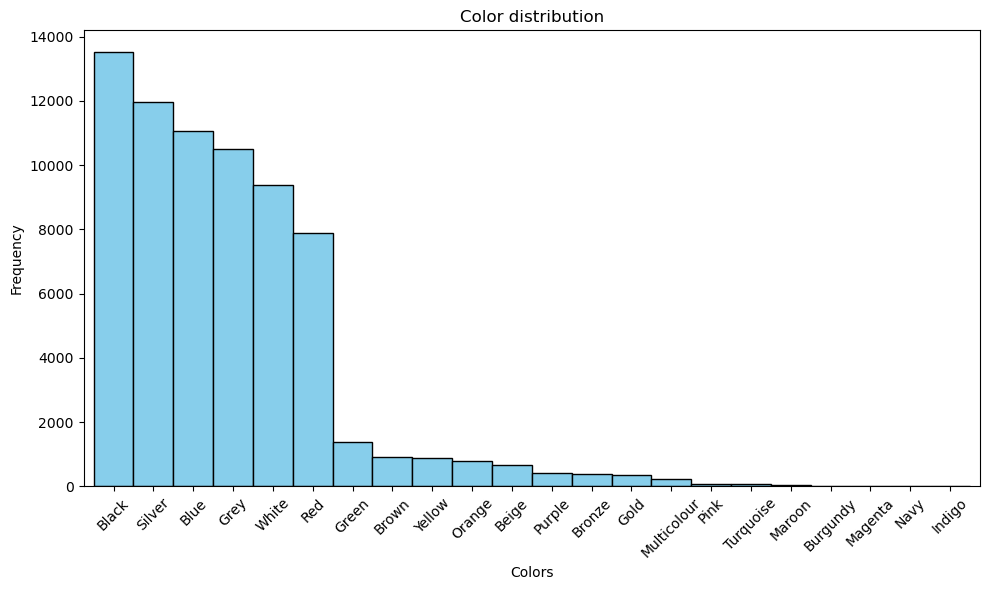

In [14]:
plot_color_distributions(df=train_color_counts)

### Validation Split

In [15]:
val_color_counts = get_color_counts(df=val_df)
val_color_counts

,Count,Percentage
Black,3469,19.663
Silver,3022,17.130
Blue,2823,16.002
Grey,2559,14.505
White,2318,13.139
Red,1843,10.447
Green,344,1.950
Yellow,235,1.332
Brown,233,1.321
Orange,202,1.145


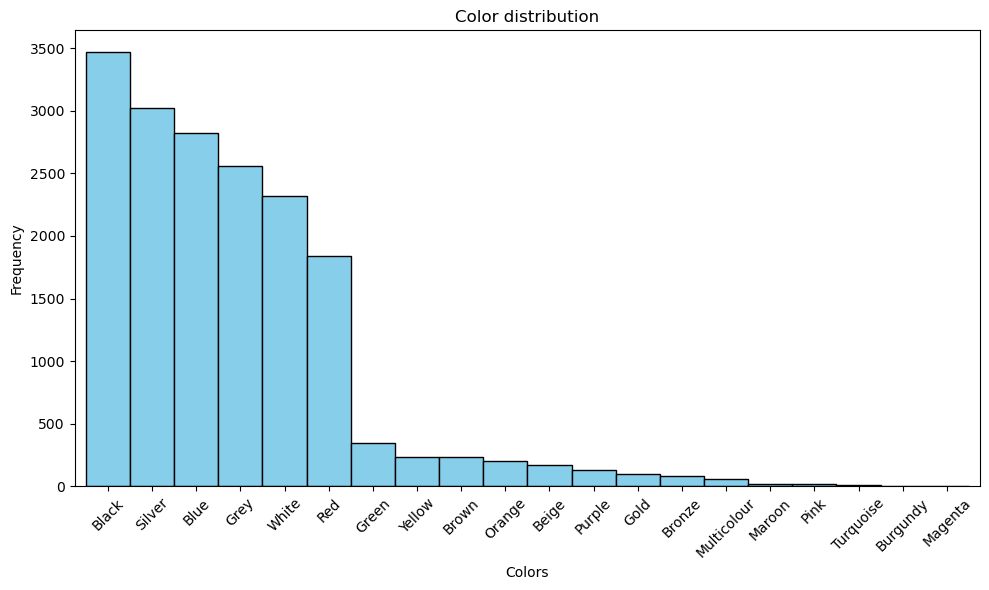

In [16]:
plot_color_distributions(df=val_color_counts)

### Test Split

In [17]:
test_color_counts = get_color_counts(df=test_df)
test_color_counts

,Count,Percentage
Black,17017,19.292
Silver,14903,16.895
Blue,13915,15.775
Grey,13082,14.831
White,11676,13.237
Red,9776,11.083
Green,1775,2.012
Brown,1149,1.303
Yellow,1103,1.250
Orange,978,1.109


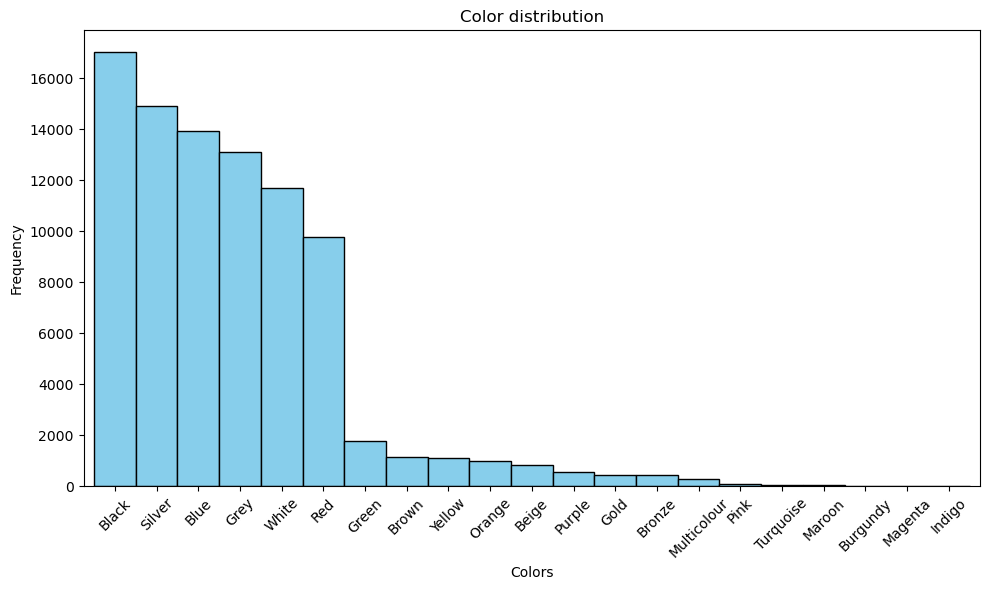

In [18]:
plot_color_distributions(df=test_color_counts)

## See if distributions are the same

In [19]:
def plot_compare_distribution(train_dist: Union[pd.Series, pd.DataFrame], val_dist: Union[pd.Series, pd.DataFrame], test_dist: Union[pd.Series, pd.DataFrame], colors: list[str]) -> None:
    plt.figure(figsize=(12, 6))
    plt.plot(colors, train_dist.reindex(colors), label='Train', marker='o')
    plt.plot(colors, val_dist.reindex(colors), label='Validation', marker='s')
    plt.plot(colors, test_dist.reindex(colors), label='Test', marker='^')
    plt.xticks(rotation=45)
    plt.ylabel('Relative Frequency')
    plt.title('Color Distribution Comparison')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [20]:
def calc_KL(first_dist: pd.DataFrame, second_dist: pd.DataFrame) -> np.ndarray:
    kl = np.sum(kl_div(first_dist, second_dist))
    return kl

In [21]:
def calc_JS(first_dist: pd.DataFrame, second_dist: pd.DataFrame) -> float:
    js = jensenshannon(first_dist, second_dist)
    return float(js)

In [22]:
colors = list(color_coding.values())

In [23]:
def fill_missing_vals(df: pd.DataFrame, colors: list[str]) -> pd.DataFrame:
    # fill missing color with 0 if it isn't present in distribution
    for color in colors:
        if color not in df:
            df[color] = 0
    return df

In [24]:
train_dist = train_color_counts['Count'] / train_color_counts['Count'].sum()
val_dist = val_color_counts['Count'] / val_color_counts['Count'].sum()
test_dist = test_color_counts['Count'] / test_color_counts['Count'].sum()

#### Calculate Kullback-Leibler divergence

In [25]:
train_val_kl = calc_KL(first_dist=train_dist, second_dist=val_dist)
train_val_kl

0.0009321821806920966

In [26]:
train_test_kl = calc_KL(first_dist=train_dist, second_dist=test_dist)
train_test_kl

0.00016459560488363636

#### Calculate Jensen Shannonen divergence

In [27]:
train_df_filled = fill_missing_vals(df=train_dist, colors=colors)
val_df_filled = fill_missing_vals(df=val_dist, colors=colors)
train_val_js = calc_JS(first_dist=train_df_filled, second_dist=val_df_filled)
train_val_js

0.013530758435503982

In [28]:
test_df_filled = fill_missing_vals(df=test_dist, colors=colors)
train_test_js = calc_JS(first_dist=train_df_filled, second_dist=test_df_filled)
train_test_js

0.006184439960490339

#### Plot the distributions 

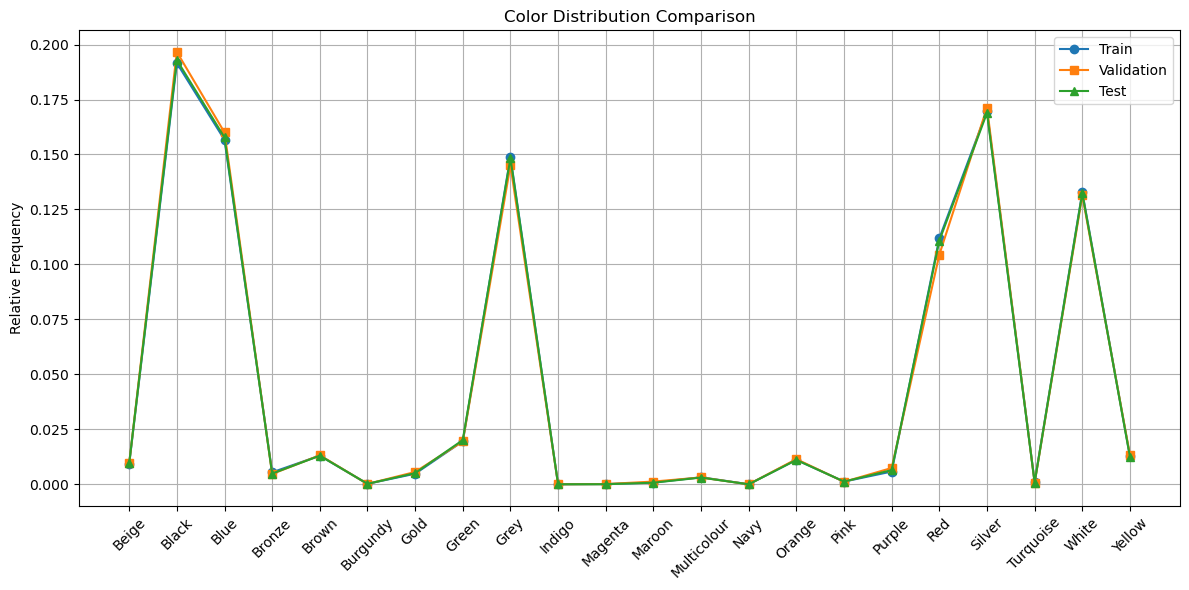

In [29]:
plot_compare_distribution(train_dist=train_dist, val_dist=val_dist, test_dist=test_dist, colors=colors)

# Create datasets that contain distribution shifts

In [30]:
def create_shifted_splits(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame, split: list[Dict[str, str]], ratio: list[float], mode: int = 0) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    '''
    Creates shifted versions of the given DataFrames.
    
    Args:
    -----
        train_df (pd.DataFrame): the original training df
        val_df (pd.DataFrame): the original validation df
        test_df (pd.DataFrame): the original test df
        split (list[Dict[str, str]]): The elements that needs to be filtered
        ratio (list[float]): Expects a list containing three float numbers:
                                first: training / validation size ratio
                                second: validation / test size ratio
                                third: training / test size ratio
        mode (int): The mode, i.e. if the newly generated test df should contain all split elements and train/val contain everything else (mode==0) or vice versa (mode==1) 
    '''
    
    train_mask = create_shift_mask(df=train_df, filters=split)
    val_mask = create_shift_mask(df=val_df, filters=split)
    test_mask = create_shift_mask(df=test_df, filters=split)
    
    train_no_df = train_df[~train_mask]
    train_only_df = train_df[train_mask]

    val_no_df = val_df[~val_mask]
    val_only_df = val_df[val_mask]

    test_no_df = test_df[~test_mask]
    test_only_df = test_df[test_mask]
    
    no_df_concatenated = pd.concat([train_no_df, val_no_df, test_no_df], axis=0)
    only_df_concatenated = pd.concat([train_only_df, val_only_df, test_only_df], axis=0)

    # the no_df_concatenated is here split into a 4:1 ratio to maintain the same train/val size difference 
    if mode == 0:
        new_train_df_concatenated = no_df_concatenated.iloc[len(no_df_concatenated) // int(ratio[0] + 1):]
        new_val_df_concatenated = no_df_concatenated.iloc[:len(no_df_concatenated) // int(ratio[0] + 1)]
        new_test_df_concatenated = only_df_concatenated
    elif mode == 1:
        new_train_df_concatenated = only_df_concatenated.iloc[len(only_df_concatenated) // int(ratio[0] + 1):]
        new_val_df_concatenated = only_df_concatenated.iloc[:len(only_df_concatenated) // int(ratio[0] + 1)]
        new_test_df_concatenated = no_df_concatenated
    else:
        raise ValueError("mode can only be 0 or 1.")
    
    # cut test df if needed
    train_size = new_train_df_concatenated.shape[0]
    val_size = new_val_df_concatenated.shape[0]
    test_size = new_test_df_concatenated.shape[0]
    
    train_test_ratio = train_size / test_size
    if train_test_ratio < ratio[2]:
        cut = int(test_size - (train_size / ratio[2]))
        new_test_df_concatenated = new_test_df_concatenated.sample(n=(test_size - cut))
        
    elif train_test_ratio > ratio[2]:
        train_cut = int(train_size - (test_size * ratio[2]))
        new_train_df_concatenated = new_train_df_concatenated.sample(n=(train_size - train_cut))
        
        val_cut = int(val_size - (test_size * ratio[1]))
        new_val_df_concatenated = new_val_df_concatenated.sample(n=(val_size - val_cut)) 
    
    
    print(f"Shape of new train df:\t{new_train_df_concatenated.shape}")
    print(f"Shape of new val df:\t{new_val_df_concatenated.shape}")
    print(f"Shape of new test df:\t{new_test_df_concatenated.shape}")
    print(f"Total Size: {new_train_df_concatenated.shape[0] + new_val_df_concatenated.shape[0] + new_test_df_concatenated.shape[0]}")
    
    return new_train_df_concatenated, new_val_df_concatenated, new_test_df_concatenated

def create_shift_mask(df: pd.DataFrame, filters: list[Dict[str, str]]) -> pd.Series:
    mask = pd.Series([True] * len(df))  # Start with all True
    for f in filters:
        for col, val in f.items():
            mask &= df[col] == val
    return mask

In [31]:
def create_dist_dfs(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame, colors: list[str] = [], fill: bool = True) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    train_color_counts = get_color_counts(df=train_df)
    train_dist = train_color_counts['Count'] / train_color_counts['Count'].sum()

    val_color_counts = get_color_counts(df=val_df)
    val_dist = val_color_counts['Count'] / val_color_counts['Count'].sum()

    test_color_counts = get_color_counts(df=test_df)
    test_dist = test_color_counts['Count'] / test_color_counts['Count'].sum()
    
    if fill and len(colors) > 0:
        train_dist = fill_missing_vals(df=train_dist, colors=colors)
        val_dist = fill_missing_vals(df=val_dist, colors=colors)
        test_dist = fill_missing_vals(df=test_dist, colors=colors)
    
    return train_dist, val_dist, test_dist

### Train, Val: No Black. Test: Only Black

In [32]:
train_no_black_df_concatenated, val_no_black_df_concatenated, test_only_black_df_concatenated = create_shifted_splits(train_df=train_df,
                                                                                                                      val_df=val_df, 
                                                                                                                      test_df=test_df, 
                                                                                                                      split=[{"Color": "Black"}],
                                                                                                                      ratio=ratio,
                                                                                                                      mode=0)

Shape of new train df:	(27204, 17)
Shape of new val df:	(6801, 17)
Shape of new test df:	(34005, 17)
Total Size: 68010


In [33]:
print(round(train_no_black_df_concatenated.shape[0] / val_no_black_df_concatenated.shape[0], 3))
print(round(val_no_black_df_concatenated.shape[0] / test_only_black_df_concatenated.shape[0], 3))
print(round(train_no_black_df_concatenated.shape[0] / test_only_black_df_concatenated.shape[0], 3))

4.0
0.2
0.8


In [34]:
train_no_black_dist, val_no_black_dist, test_only_black_dist = create_dist_dfs(train_df=train_no_black_df_concatenated,
                                                                               val_df=val_no_black_df_concatenated,
                                                                               test_df=test_only_black_df_concatenated,
                                                                               colors=colors)

In [35]:
train_test_kl_no_black = calc_JS(first_dist=train_no_black_dist, second_dist=test_only_black_dist)
train_test_kl_no_black

0.6423138622910217

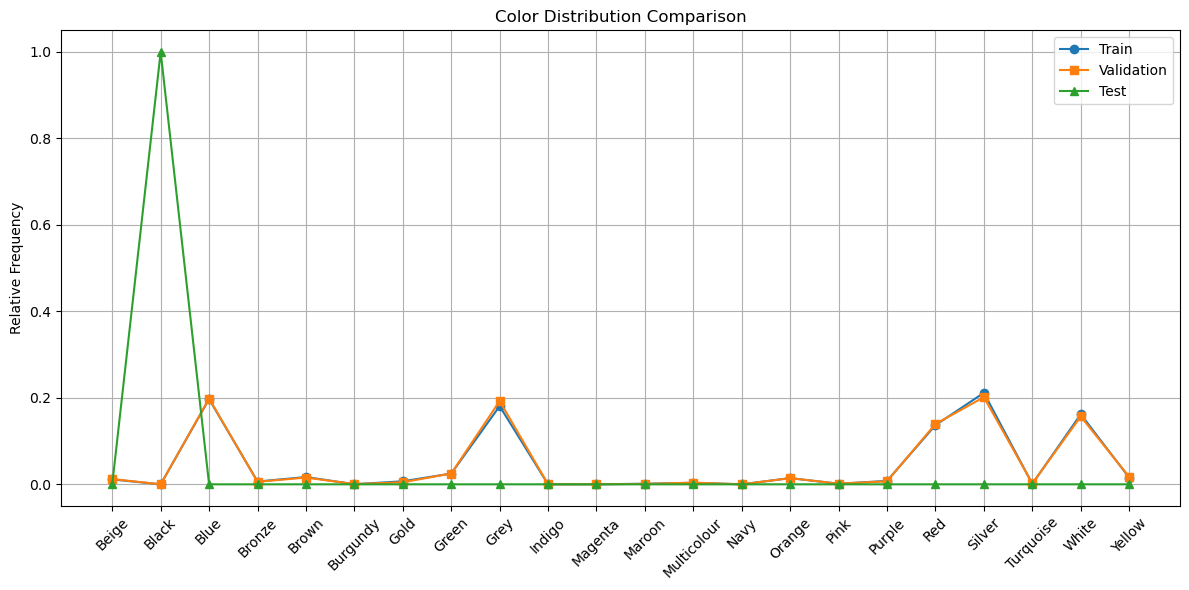

In [36]:
plot_compare_distribution(train_dist=train_no_black_dist, val_dist=val_no_black_dist, test_dist=test_only_black_dist, colors=colors)

### Train, Val: Only Black. Test: No Black

In [37]:
train_only_black_df_concatenated, val_only_black_df_concatenated, test_no_black_df_concatenated = create_shifted_splits(train_df=train_df,
                                                                                                                      val_df=val_df, 
                                                                                                                      test_df=test_df, 
                                                                                                                      split=[{"Color": "Black"}],
                                                                                                                      ratio=ratio,
                                                                                                                      mode=1)

Shape of new train df:	(27204, 17)
Shape of new val df:	(6801, 17)
Shape of new test df:	(34005, 17)
Total Size: 68010


In [38]:
print(round(train_only_black_df_concatenated.shape[0] / val_only_black_df_concatenated.shape[0], 3))
print(round(val_only_black_df_concatenated.shape[0] / test_no_black_df_concatenated.shape[0], 3))
print(round(train_only_black_df_concatenated.shape[0] / test_no_black_df_concatenated.shape[0], 3))

4.0
0.2
0.8


In [39]:
train_only_black_dist, val_only_black_dist, test_no_black_dist = create_dist_dfs(train_df=train_only_black_df_concatenated,
                                                                               val_df=val_only_black_df_concatenated,
                                                                               test_df=test_no_black_df_concatenated,
                                                                               colors=colors)

In [40]:
train_test_kl_only_black = calc_JS(first_dist=train_only_black_dist, second_dist=test_no_black_dist)
train_test_kl_only_black

0.6413958021861573

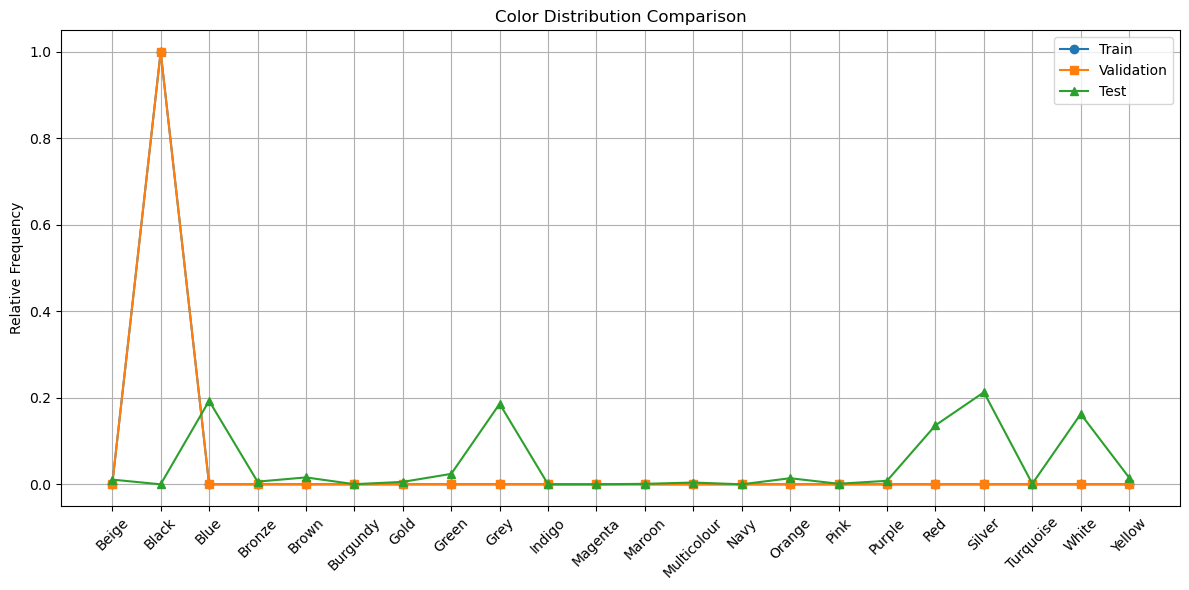

In [41]:
plot_compare_distribution(train_dist=train_only_black_dist, val_dist=val_only_black_dist, test_dist=test_no_black_dist, colors=colors)

In [42]:
import torch
all_lables_path = os.path.join(FEATURES, "train_paths_all_views_0.01.pt")

data = torch.load(all_lables_path, map_location='cpu')
data

array(['/mnt/data/kgutjahr/datasets/DVM/images/Volkswagen/Eos/2006/Silver/Volkswagen$$Eos$$2006$$Silver$$95_13$$46$$image_0.jpg',
       '/mnt/data/kgutjahr/datasets/DVM/images/Fiat/500/2009/Silver/Fiat$$500$$2009$$Silver$$28_2$$988$$image_0.jpg',
       '/mnt/data/kgutjahr/datasets/DVM/images/Citroen/C4 Cactus/2016/Blue/Citroen$$C4 Cactus$$2016$$Blue$$18_13$$216$$image_1.jpg',
       '/mnt/data/kgutjahr/datasets/DVM/images/Volkswagen/Sharan/2015/Grey/Volkswagen$$Sharan$$2015$$Grey$$95_24$$496$$image_0.jpg',
       '/mnt/data/kgutjahr/datasets/DVM/images/Volvo/XC60/2010/Black/Volvo$$XC60$$2010$$Black$$96_16$$712$$image_0.jpg',
       '/mnt/data/kgutjahr/datasets/DVM/images/Vauxhall/Zafira/2007/Silver/Vauxhall$$Zafira$$2007$$Silver$$94_27$$201$$image_1.jpg',
       '/mnt/data/kgutjahr/datasets/DVM/images/Renault/Megane/2005/Black/Renault$$Megane$$2005$$Black$$75_12$$912$$image_1.jpg',
       '/mnt/data/kgutjahr/datasets/DVM/images/Land Rover/Discovery/2018/Grey/Land Rover$$Discovery$$20

In [75]:
lables_path = os.path.join(FEATURES, "labels_model_all_train_all_views_0.1.pt")
paths_path = os.path.join(FEATURES, "train_paths_all_views_0.1.pt")

lables = label_data = torch.load(all_lables_path, map_location='cpu')
paths = torch.load(paths_path, map_location='cpu')

mapped_labeles = [label_coding.get(key, None) for key in lables]
for p, l in zip(paths, mapped_labeles):
    print(f"Label: {l}, Path: {p}")

Label: Mazda Mazda5, Path: /mnt/data/kgutjahr/datasets/DVM/images/Volkswagen/Eos/2006/Silver/Volkswagen$$Eos$$2006$$Silver$$95_13$$46$$image_0.jpg
Label: None, Path: /mnt/data/kgutjahr/datasets/DVM/images/Fiat/500/2009/Silver/Fiat$$500$$2009$$Silver$$28_2$$988$$image_0.jpg
Label: None, Path: /mnt/data/kgutjahr/datasets/DVM/images/Citroen/C4 Cactus/2016/Blue/Citroen$$C4 Cactus$$2016$$Blue$$18_13$$216$$image_1.jpg
Label: Mazda CX-5, Path: /mnt/data/kgutjahr/datasets/DVM/images/Volkswagen/Sharan/2015/Grey/Volkswagen$$Sharan$$2015$$Grey$$95_24$$496$$image_0.jpg
Label: Mercedes-Benz CLK, Path: /mnt/data/kgutjahr/datasets/DVM/images/Volvo/XC60/2010/Black/Volvo$$XC60$$2010$$Black$$96_16$$712$$image_0.jpg
Label: None, Path: /mnt/data/kgutjahr/datasets/DVM/images/Vauxhall/Zafira/2007/Silver/Vauxhall$$Zafira$$2007$$Silver$$94_27$$201$$image_1.jpg
Label: None, Path: /mnt/data/kgutjahr/datasets/DVM/images/Renault/Megane/2005/Black/Renault$$Megane$$2005$$Black$$75_12$$912$$image_1.jpg
Label: Fiat 5

0.014501194168207006
0.0008570622540410719


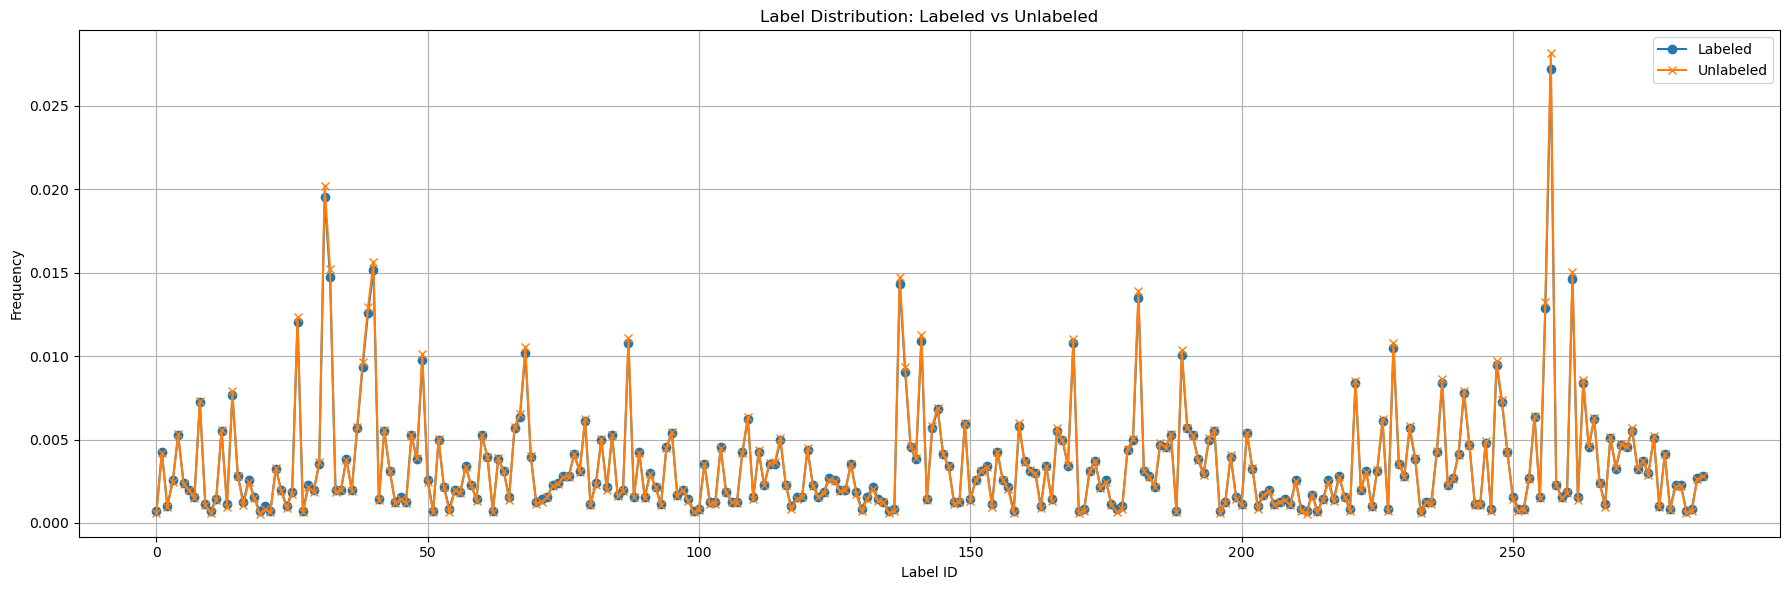

In [70]:
all_unlables_path = os.path.join(FEATURES, "labels_model_all_train_all_views_0.9.pt")
all_lables_path = os.path.join(FEATURES, "labels_model_all_train_all_views_0.1.pt")

label_data = torch.load(all_lables_path, map_location='cpu')

unlabel_data = torch.load(all_unlables_path, map_location='cpu')

from collections import Counter
label_counts = Counter(label_data)
unlabel_counts = Counter(unlabel_data)

# Get sorted list of all label IDs (for alignment)
all_labels = sorted(set(label_counts.keys()) | set(unlabel_counts.keys()))

# Create aligned frequency arrays
label_freqs = np.array([label_counts.get(l, 0) for l in all_labels])
unlabel_freqs = np.array([unlabel_counts.get(l, 0) for l in all_labels])

label_freqs_norm = label_freqs / label_freqs.sum()
unlabel_freqs_norm = unlabel_freqs / unlabel_freqs.sum()

print(jensenshannon(label_freqs_norm, unlabel_freqs_norm))
print(sum(kl_div(label_freqs_norm, unlabel_freqs_norm)))

plt.figure(figsize=(18, 6))
plt.plot(all_labels, label_freqs_norm, label="Labeled", marker='o')
plt.plot(all_labels, unlabel_freqs_norm, label="Unlabeled", marker='x')
plt.title("Label Distribution: Labeled vs Unlabeled")
plt.xlabel("Label ID")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()